# Coreteva Analysis
**Alex Brown** 2022-03-31

<alexander.c.brown319@gmail.com>
*(319) 830-9284*


# objective
The objective of this of this code is to do some exploratory analysis on a dataset provided by Corteva Agriscience. I will use python to read `.csv` a `.zip` object from an AWS s3 bucket, conduct minor clean up on the dataset after initial investigations of the dataset, and try to extract useful information with best practices in mind. 
# read-in/load
I will use the python package `boto3` to read the file from `s3`, `zipfile` to open the data, and then print the name of the files out that we are reading them in.


In [2]:
import boto3
import io
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
# import geopandas as gpd

I will enter my credentials and bucket information here for AWS.

In [5]:
# bucket
s3_bucket = 'alexb523-case-studies'
zip_file = 'corteva/cortevainterviewcasedataset.zip'

session = boto3.session.Session(
    aws_access_key_id='<aws_access_key_id>', 
    aws_secret_access_key='<aws_secret_access_key>'
)

s3 = session.resource('s3')
bucket = s3.Bucket(s3_bucket)
obj = bucket.Object(zip_file)

I’ve done some minor exploration of the contents of the zipped folder and know there are `.csv’ files within it. I will print out the names of the files as I read them in.

In [6]:
with io.BytesIO(obj.get()["Body"].read()) as tf:

    # rewind the file
    tf.seek(0)

    # read the file as a zipfile and process the members
    with zipfile.ZipFile(tf, mode='r') as zip_file:
        for subfile in zip_file.namelist():
            print(subfile)
            with zip_file.open(subfile) as sf:
                df = pd.read_csv(sf)

cortevainterviewcasedataset.csv


Here we can review the first few rows of the file. The file appears to be information about customer visits to different Corteva and Pioneer websites.

In [7]:
df.head(10)

,contactID,IPAddress,contactStatus,timeStamp,activityId,WebUrl,Referrer,ActivityType,Coordinates
0,EOO499157,136.94.170.42,Unknown,2020-01-05 00:00:36,30000,https://www.pioneer.com/us/agronomy-science.html,Google Search,PageView,NaN
1,EOO355635,252.195.39.208,Known Prospect,2020-01-05 00:00:56,30001,https://www.corteva.us/products-and-solutions/...,Eloqua Email,PageView,NaN
2,EOO121395,165.241.78.219,Customer,2020-01-05 00:01:01,30002,https://www.pioneer.com/us/agronomy-science/Pr...,Eloqua Email,PageView,"45.0408,-93.263"
3,EOO266405,255.200.180.74,Unknown,2020-01-05 00:01:28,30003,https://www.youtube.com/watch,Facebook,PageView,"40.68066,-73.47429"
4,EOO306884,84.48.210.117,Unknown,2020-01-05 00:02:13,30004,https://www.corteva.us/Resources/inputs-and-in...,NaN,PageView,NaN
5,EOO460379,30.54.180.118,Unknown,2020-01-05 00:02:34,30005,http://app.engage.corteva.com/e/es,NaN,PageView,"39.72943,-104.83192"
6,EOO12468,55.77.27.188,Customer,2020-01-05 00:02:58,30006,https://www.pioneer.com/us/agronomy-science/Pr...,Eloqua Email,PageView,"32.42067,-104.22884"
7,EOO55850,123.70.7.58,Customer,2020-01-05 00:02:59,30007,https://www.pioneer.com/us/agronomy-science/Pr...,Facebook,PageView,"35.88264,-80.08199"
8,EOO192426,80.130.246.80,Unknown,2020-01-05 00:03:19,30008,http://www.pioneer.com/checkin,Eloqua Email,PageView,"39.43534,-84.20299"
9,EOO175290,178.95.65.138,Customer,2020-01-05 00:03:55,30009,https://engage.corteva.com/US_contact-us,Google Search,PageView,"47.38093,-122.23484"


Now we will print some structural information about the file. We can see from the tables below there are 3 million rows in the data set with most of the records filled in on each column.

With these tables, we’ve already made our first discovery! Notice in the `number of unique values` table that there are a limited number of `contactids` and `ipaddresses`. This likely means that there are re-occurring visitors to most of Corteva’s websites. To be more exact, roughly 17% of the traffic on Corteva’s websites are repeat visitors.

In [146]:
# basic column info and stats
print('basic summary of the file')
print(df.info())

print('\n')

print('number of nulls or blanks in each column')
print(df.isna().sum())

print('\n')

n = df.nunique(axis=0)  
print('number of unquie values in each column :\n', n)

basic summary of the file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   contactID      object
 1   IPAddress      object
 2   contactStatus  object
 3   timeStamp      object
 4   activityId     int64 
 5   WebUrl         object
 6   Referrer       object
 7   ActivityType   object
 8   Coordinates    object
dtypes: int64(1), object(8)
memory usage: 206.0+ MB
None


number of nulls or blanks in each column
contactID              0
IPAddress              0
contactStatus          0
timeStamp              0
activityId             0
WebUrl                 0
Referrer         1285279
ActivityType           0
Coordinates       602191
dtype: int64


number of unquie values in each column :
 contactID         499560
IPAddress         499524
contactStatus          3
timeStamp        2932213
activityId       3000000
WebUrl              2079
Referrer               3
Activity

In addition, you can see from the `number of unique values` table that there are some categorical variables that can easily be grouped. We will take a closer look at these below.

In [147]:
print('count of contactStatus')
print(df.groupby(['contactStatus']).size().reset_index(name='counts'))

print('\n')

print('count of Referrer')
print(df.groupby(['Referrer']).size().reset_index(name='counts'))

count of contactStatus
    contactStatus   counts
0        Customer  1000152
1  Known Prospect  1000447
2         Unknown   999401


count of Referrer
        Referrer  counts
0   Eloqua Email  857193
1       Facebook  428609
2  Google Search  428919


The below gives us a somewhat random sample of the number of visits to each Corteva website.

In [148]:
print(df.groupby(['WebUrl']).size().reset_index(name='counts'))

                                                 WebUrl  counts
0     http://10.207.11.226:4502//content/dam/dpagco/...     330
1     http://10.207.11.226:4502/content/corteva/corp...     355
2             http://10.226.141.196:4502/bin/wcmcommand     304
3     http://10.226.141.228:4502/content/corteva/na/...     335
4     http://10.226.71.228:4503/content/corteva/na/u...     327
...                                                 ...     ...
2074                       https://youtu.be/pecVtrAXbkQ     349
2075                       https://youtu.be/tAQ2jFpfCSw     361
2076                       https://youtu.be/vR3B9DuckMs     314
2077                       https://youtu.be/vyTenDXHu44    2447
2078                       https://youtu.be/x6yWmcV6-Uk     320

[2079 rows x 2 columns]


# transformation
Now that we have done an initial peek at the data, we will do some transformation and add some features. Mainly, we will break apart the date column so we can plot a time series of the data and coordinates into latitude and longitude so we can plot a geo-map of the website visits.

In addition, I will change all the columns to lowercase for better consistency and standardization to column names when coding.

Below shows some an update view of our data set.

In [149]:
# minor transforming

df_clean = df

df_clean[['Latitude','Longitude']] = df_clean.Coordinates.str.split(",", expand=True, n=-1) # separate coordinates
df_clean[['Latitude','Longitude']] = df_clean[['Latitude','Longitude']].apply(pd.to_numeric, errors='coerce')
df_clean[['timeStamp']] = pd.to_datetime(df_clean['timeStamp'])
df_clean['Year'] = df_clean['timeStamp'].dt.year  # extracting year
df_clean['Quarter'] = df_clean['timeStamp'].dt.quarter # extracting quarter
df_clean['Month'] = df_clean['timeStamp'].dt.month # extracting month
df_clean['YearMonth'] = pd.to_datetime(df_clean['timeStamp']).dt.to_period('M') # creating a year-month field
df_clean.columns = map(str.lower, df_clean.columns)

df_clean.head(5)

,contactid,ipaddress,contactstatus,timestamp,activityid,weburl,referrer,activitytype,coordinates,latitude,longitude,year,quarter,month,yearmonth
0,EOO499157,136.94.170.42,Unknown,2020-01-05 00:00:36,30000,https://www.pioneer.com/us/agronomy-science.html,Google Search,PageView,NaN,NaN,NaN,2020,1,1,2020-01
1,EOO355635,252.195.39.208,Known Prospect,2020-01-05 00:00:56,30001,https://www.corteva.us/products-and-solutions/...,Eloqua Email,PageView,NaN,NaN,NaN,2020,1,1,2020-01
2,EOO121395,165.241.78.219,Customer,2020-01-05 00:01:01,30002,https://www.pioneer.com/us/agronomy-science/Pr...,Eloqua Email,PageView,"45.0408,-93.263",45.04080,-93.26300,2020,1,1,2020-01
3,EOO266405,255.200.180.74,Unknown,2020-01-05 00:01:28,30003,https://www.youtube.com/watch,Facebook,PageView,"40.68066,-73.47429",40.68066,-73.47429,2020,1,1,2020-01
4,EOO306884,84.48.210.117,Unknown,2020-01-05 00:02:13,30004,https://www.corteva.us/Resources/inputs-and-in...,NaN,PageView,NaN,NaN,NaN,2020,1,1,2020-01


In [150]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   contactid      object        
 1   ipaddress      object        
 2   contactstatus  object        
 3   timestamp      datetime64[ns]
 4   activityid     int64         
 5   weburl         object        
 6   referrer       object        
 7   activitytype   object        
 8   coordinates    object        
 9   latitude       float64       
 10  longitude      float64       
 11  year           int64         
 12  quarter        int64         
 13  month          int64         
 14  yearmonth      period[M]     
dtypes: datetime64[ns](1), float64(2), int64(4), object(7), period[M](1)
memory usage: 343.3+ MB


# exploration

### time-series
The below graph shows a time series analysis of traffic to Corteva websites. This graph shows the data set expands from the beginning of 2020 until early 2022. The colors of the graph separate the year. We can see there is a slight trend of more traffic during the warmer months from March to September.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

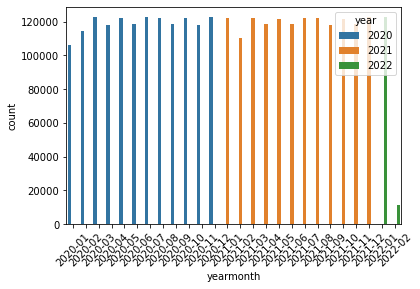

In [151]:
ax = sns.countplot(x='yearmonth', data=df_clean, hue='year')
plt.xticks(rotation=45)

### top-ten

Next, we will review Corteva’s top 10 most visited websites. We can see there are some websites that approach 50,000 visits over the last 2+ years. In general, it would be worth exploring these top websites further and understanding why they have the top views.

One thing that really sticks out to me in these top 10 websites is `youtube.com/watch` website. This `url` leads to YouTube.com’s main page. This could be a sign of a bug in the process or better understanding the way the system is capturing data. For now, we will ignore this discrepancy and put it on the back log list to investigate further.


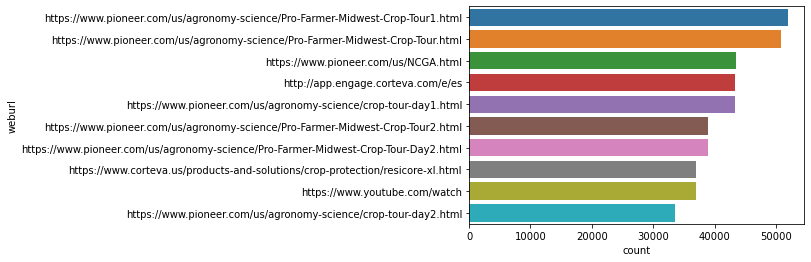

In [152]:
sns.countplot(y="weburl", data=df_clean, order=df_clean.weburl.value_counts().iloc[:10].index)

# location-location-location

To understand more about were where Corteva’s website visits are coming from, we will look at the `referrer` column in association with location. Form the `count of Referrer` table above, we can see Eloqua’s Email is the source of most of the Corteva website visits. With the table below we can now visibly see where those views are coming from in the US

The map show clusters of visits to Corteva websites throughout the US, mainly I flatter parts of the country.


In [153]:
map_df = df_clean[df_clean['coordinates'].notnull()]

map_df[['referrer']] = map_df[['referrer']].fillna('Unknown')
# extract the data we're interested in
# lat = map_df['latitude'].values
# lon = map_df['longitude'].values
# ref = map_df['referrer'].values

colors = {'Eloqua Email':'blue', 'Google Search':'orange', 'Facebook':'green', 'Unknown':'grey'}

c:\users\abrow\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


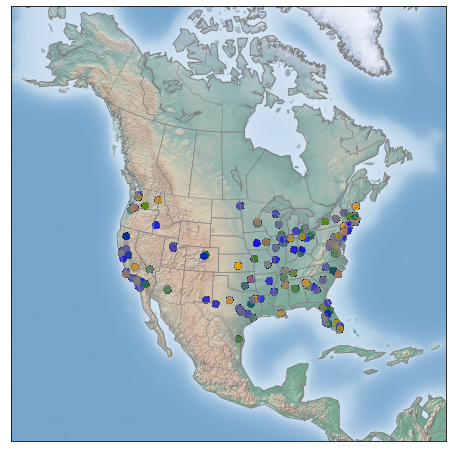

In [154]:
# draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', 
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m

# scatter city data, with
# color reflecting referrer
# and size reflecting counts
m.scatter(map_df['longitude'], map_df['latitude'],
          latlon=True,
          c=map_df['referrer'].map(colors),
          # s=area,
          # cmap='Reds',
          alpha=0.5)

# further research
The next steps in this analysis would be to investigate repeat contacts. In particular, it would be good to understand what websites customers and prospects are interacting with regularly. This could enable Corteva to study what turns a prospect into a customer and advertise for cross-selling and to new prospects.
